# Development of Algorithms for ERDDAP Dataset from 2nd Narrows HADCP Observations

Figuring out how to transform 2nd Narrows horizontal ADCP observations from
AIS CSV files into a netCDF file that is part of an ERDDAP dataset:

* Read CSV file into `pandas` dataframe
* Filter to include only 2nd Narrow HADCP rows
* Convert to `xarray.Dataset`
* Add metadata

* **BONUS:** Add observations from an hourly file to an existing netCDF file
so that we can have daily or monthly netCDF instead of hourly

In [1]:
from pathlib import Path

import arrow
import pandas
import numpy
import xarray

In [2]:
%matplotlib inline

## Inspect a Sample `csv` File

In [3]:
!wc -l /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv

229 /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv


In [4]:
!head /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv

"28/09/2018 05:00 - 28/09/2018 06:00  [ 28/09/2018 12:00 UTC - 28/09/2018 13:00 UTC ]"
"SoG Weather Stations"
"SoG Weather Stations"
"Name","MMSI","Time","Wind Speed","Wind Dir.","Wind Gust","Wind Gust Dir.","Air Temp.","Air Pres.","Water Level","Water Temp.","Currrent Speed","Current Dir."
"VFPA CN RAIL BRIDGE","003160171","28/09/2018 05:00","","","","","-0.1","","2.3","-0.1","2.9","85"
"VFPA CN RAIL BRIDGE","003160171","28/09/2018 05:00","","","","","-0.1","","2.3","-0.1","2.9","85"
"NPA WEATHER","993161006","28/09/2018 05:00","3","159","3","161","13.3","1014","2.5","-0.1","",""
"NPA WEATHER","993161006","28/09/2018 05:00","3","159","3","161","13.3","1014","2.5","-0.1","",""
"DUKE POINT ATON","993161010","28/09/2018 05:00","10","10","13","10","15.6","1015","2.3","12.3","0.5","88"
"DUKE POINT ATON","993161010","28/09/2018 05:01","8","11","13","10","15.4","1015","2.3","12.3","0.5","88"


In [5]:
!tail /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv

"NPA WEATHER","993161006","28/09/2018 05:54","0","123","1","110","13.2","1014","3","-0.1","",""
"NPA WEATHER","993161006","28/09/2018 05:54","0","123","1","110","13.2","1014","3","-0.1","",""
"DUKE POINT ATON","993161010","28/09/2018 05:55","3","322","5","318","13.9","1015","2.9","11.8","0.4","77"
"VFPA CN RAIL BRIDGE","003160171","28/09/2018 05:56","","","","","-0.1","","2.8","-0.1","3","86"
"DUKE POINT ATON","993161010","28/09/2018 05:56","3","322","5","318","13.6","1015","2.9","11.8","0.4","77"
"","003160011","28/09/2018 05:57","17","312","","","14.8","","3.2","","",""
"NPA WEATHER","993161006","28/09/2018 05:57","1","169","2","160","13.4","1014","3","-0.1","",""
"VFPA CN RAIL BRIDGE","003160171","28/09/2018 05:58","","","","","-0.1","","2.9","-0.1","3","86"
"VFPA CN RAIL BRIDGE","003160171","28/09/2018 05:58","","","","","-0.1","","2.9","-0.1","3","86"



In [6]:
!wc -l /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv

229 /opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv


## Read `csv` File into a `panada.Dataframe`

In [7]:
all_df = pandas.read_csv('/opp/observations/AISDATA/20180928T120000Z-20180928T130000Z.csv', skiprows=3)
all_df

,Name,MMSI,Time,Wind Speed,Wind Dir.,Wind Gust,Wind Gust Dir.,Air Temp.,Air Pres.,Water Level,Water Temp.,Currrent Speed,Current Dir.
0,VFPA CN RAIL BRIDGE,3160171,28/09/2018 05:00,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
1,VFPA CN RAIL BRIDGE,3160171,28/09/2018 05:00,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
2,NPA WEATHER,993161006,28/09/2018 05:00,3.0,159.0,3.0,161.0,13.3,1014.0,2.5,-0.1,NaN,NaN
3,NPA WEATHER,993161006,28/09/2018 05:00,3.0,159.0,3.0,161.0,13.3,1014.0,2.5,-0.1,NaN,NaN
4,DUKE POINT ATON,993161010,28/09/2018 05:00,10.0,10.0,13.0,10.0,15.6,1015.0,2.3,12.3,0.5,88.0
5,DUKE POINT ATON,993161010,28/09/2018 05:01,8.0,11.0,13.0,10.0,15.4,1015.0,2.3,12.3,0.5,88.0
6,VFPA CN RAIL BRIDGE,3160171,28/09/2018 05:02,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
7,VFPA CN RAIL BRIDGE,3160171,28/09/2018 05:02,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
8,VFPA CN RAIL BRIDGE,3160171,28/09/2018 05:02,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
9,NaN,3160011,28/09/2018 05:02,NaN,NaN,NaN,NaN,NaN,NaN,2.7,NaN,NaN,NaN


## Isolate 2nd Narrows Observations

* Drop duplicated rows
* Use the `Time` column as the index

In [8]:
hadcp_df = all_df.loc[all_df.MMSI == 3160171].drop_duplicates().set_index('Time')
hadcp_df.index = pandas.to_datetime(hadcp_df.index, format='%d/%m/%Y %H:%M')
hadcp_df

,Name,MMSI,Wind Speed,Wind Dir.,Wind Gust,Wind Gust Dir.,Air Temp.,Air Pres.,Water Level,Water Temp.,Currrent Speed,Current Dir.
Time,,,,,,,,,,,,
2018-09-28 05:00:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
2018-09-28 05:02:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
2018-09-28 05:04:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
2018-09-28 05:06:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.3,-0.1,2.9,85.0
2018-09-28 05:08:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.4,-0.1,3.0,84.0
2018-09-28 05:10:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.4,-0.1,2.9,85.0
2018-09-28 05:12:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.4,-0.1,2.9,85.0
2018-09-28 05:14:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.4,-0.1,2.9,85.0
2018-09-28 05:16:00,VFPA CN RAIL BRIDGE,3160171,NaN,NaN,NaN,NaN,-0.1,NaN,2.5,-0.1,2.9,85.0


## Isolate the Seawater Current Observations

* Drop the columns that are full of `N/A`s
* Drop other columns we're not interested in by name
* Rename the index to `time`
* Simplify the current speed and direction column names

In [9]:
xr_df = hadcp_df \
    .dropna(axis='columns', how='all') \
    .drop(['Name', 'MMSI', 'Air Temp.', 'Water Temp.', 'Water Level'], axis='columns')
xr_df.index.name = 'time'
xr_df.columns = ('speed', 'direction')
xr_df

,speed,direction
time,,
2018-09-28 05:00:00,2.9,85.0
2018-09-28 05:02:00,2.9,85.0
2018-09-28 05:04:00,2.9,85.0
2018-09-28 05:06:00,2.9,85.0
2018-09-28 05:08:00,3.0,84.0
2018-09-28 05:10:00,2.9,85.0
2018-09-28 05:12:00,2.9,85.0
2018-09-28 05:14:00,2.9,85.0
2018-09-28 05:16:00,2.9,85.0


## Store Observations in netCDF4 File

* transform the `pandas.Dataframe` into an `xarray.Dataset`
* define encoding for netCDF4 serialization
* write to file

In [10]:
ds = xarray.Dataset.from_dataframe(xr_df)
ds

<xarray.Dataset>
Dimensions:    (time: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-28T05:00:00 ... 2018-09-28T05:58:00
Data variables:
    speed      (time) float64 2.9 2.9 2.9 2.9 3.0 2.9 ... 3.0 3.0 3.0 3.0 3.0
    direction  (time) float64 85.0 85.0 85.0 85.0 84.0 ... 86.0 86.0 86.0 86.0

Compress the speed and direction observation values by scaling them
to that they are stored with a precision of 0.1 in 16-bit integers
and with `NaN`s converted to `-9999`.

Use the default `proleptic_gregorian` calendar for times and
store them as seconds since the Unix epoch.

Set the `time` dimension as unlimited to make concatenation easy.

In [11]:
encoding={
    'speed': {'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -9999},
    'direction': {'dtype': 'int16', 'scale_factor': 0.1, '_FillValue': -9999},
    'time': {'units': 'seconds since 1970-01-01T00:00:00Z'},
}

In [12]:
ds.to_netcdf('/tmp/foo.nc', mode='w', encoding=encoding, unlimited_dims='time')

## Inspect the netCDF4 File

In [13]:
!ls -lh /tmp/foo.nc

-rw-r--r-- 1 doug doug 18K Oct 11 18:42 /tmp/foo.nc


In [14]:
!ncdump -cst /tmp/foo.nc

netcdf foo {
dimensions:
	time = UNLIMITED ; // (30 currently)
variables:
	int64 time(time) ;
		time:units = "seconds since 1970-01-01T00:00:00+00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 512 ;
		time:_Endianness = "little" ;
	short speed(time) ;
		speed:_FillValue = -9999s ;
		speed:scale_factor = 0.1 ;
		speed:_Storage = "chunked" ;
		speed:_ChunkSizes = 30 ;
		speed:_Endianness = "little" ;
	short direction(time) ;
		direction:_FillValue = -9999s ;
		direction:scale_factor = 0.1 ;
		direction:_Storage = "chunked" ;
		direction:_ChunkSizes = 30 ;
		direction:_Endianness = "little" ;

// global attributes:
		:_NCProperties = "version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2" ;
		:_SuperblockVersion = 0 ;
		:_IsNetcdf4 = 1 ;
		:_Format = "netCDF-4" ;
data:

 time = "2018-09-28 05", "2018-09-28 05:01:60.000000", 
    "2018-09-28 05:03:60.000000", "2018-09-28 05:05:60.000000", 
    "2018-09-28 05:08:0.000000", "2018-09-28 05

In [15]:
currents = xarray.open_dataset('/tmp/foo.nc')
currents

<xarray.Dataset>
Dimensions:    (time: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-28T05:00:00 ... 2018-09-28T05:58:00
Data variables:
    speed      (time) float32 ...
    direction  (time) float32 ...

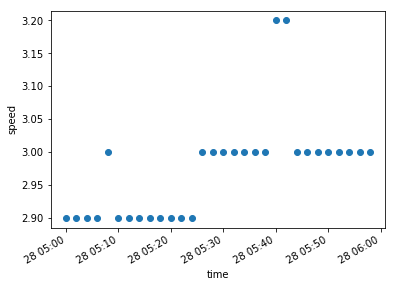

In [16]:
currents.speed.plot(marker='o', linestyle='None')

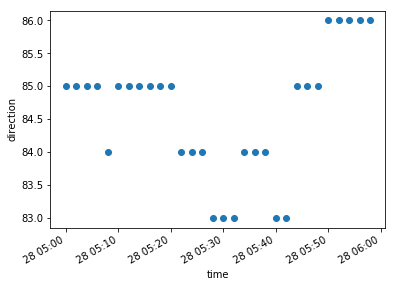

In [17]:
currents.direction.plot(marker='o', linestyle='None')

## Concatenate Observations from Another `csv` to the netCDF4 File

In [18]:
def csv_to_dataset(csv_file):
    df = pandas.read_csv(csv_file, skiprows=3)
    df = df.loc[df.Name == 'VFPA CN RAIL BRIDGE'].drop_duplicates().set_index('Time')
    df = df.dropna(axis='columns', how='all')
    df = df.drop(['Name', 'MMSI', 'Air Temp.', 'Water Temp.', 'Water Level'], axis='columns')
    df.index = pandas.to_datetime(df.index, format='%d/%m/%Y %H:%M')
    df.index.name = 'time'
    df.columns = ('speed', 'direction')
    return xarray.Dataset.from_dataframe(df)

In [19]:
ds = csv_to_dataset('/opp/observations/AISDATA/20180928T130000Z-20180928T140000Z.csv')
ds

<xarray.Dataset>
Dimensions:    (time: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-28T06:00:00 ... 2018-09-28T06:58:00
Data variables:
    speed      (time) float64 3.0 3.1 3.1 3.1 3.1 3.1 ... 3.0 3.0 3.0 2.9 3.0
    direction  (time) float64 86.0 86.0 85.0 85.0 86.0 ... 85.0 85.0 84.0 85.0

In [20]:
currents = xarray.open_dataset('/tmp/foo.nc')
extended_currents = xarray.concat((currents, ds), dim='time')
extended_currents

<xarray.Dataset>
Dimensions:    (time: 60)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-28T05:00:00 ... 2018-09-28T06:58:00
Data variables:
    speed      (time) float64 2.9 2.9 2.9 2.9 3.0 2.9 ... 3.0 3.0 3.0 2.9 3.0
    direction  (time) float64 85.0 85.0 85.0 85.0 84.0 ... 85.0 85.0 84.0 85.0

In [21]:
extended_currents.to_netcdf('/tmp/bar.nc', mode='w', encoding=encoding, unlimited_dims='time')

File only increases in size by 120 bytes!!

That bodes well for the idea of storing month-long netCDF4 files for ERDDAP.

In [22]:
!ls -l /tmp/bar.nc

-rw-r--r-- 1 doug doug 17555 Oct 11 18:42 /tmp/bar.nc


In [23]:
!ls -l /tmp/foo.nc

-rw-r--r-- 1 doug doug 17435 Oct 11 18:42 /tmp/foo.nc


In [24]:
!ncdump -cst /tmp/bar.nc

netcdf bar {
dimensions:
	time = UNLIMITED ; // (60 currently)
variables:
	int64 time(time) ;
		time:units = "seconds since 1970-01-01T00:00:00+00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 512 ;
		time:_Endianness = "little" ;
	short speed(time) ;
		speed:_FillValue = -9999s ;
		speed:scale_factor = 0.1 ;
		speed:_Storage = "chunked" ;
		speed:_ChunkSizes = 60 ;
		speed:_Endianness = "little" ;
	short direction(time) ;
		direction:_FillValue = -9999s ;
		direction:scale_factor = 0.1 ;
		direction:_Storage = "chunked" ;
		direction:_ChunkSizes = 60 ;
		direction:_Endianness = "little" ;

// global attributes:
		:_NCProperties = "version=1|netcdflibversion=4.6.1|hdf5libversion=1.10.2" ;
		:_SuperblockVersion = 0 ;
		:_IsNetcdf4 = 1 ;
		:_Format = "netCDF-4" ;
data:

 time = "2018-09-28 05", "2018-09-28 05:01:60.000000", 
    "2018-09-28 05:03:60.000000", "2018-09-28 05:05:60.000000", 
    "2018-09-28 05:08:0.000000", "2018-09-28 05

In [25]:
currents = xarray.open_dataset('/tmp/bar.nc')
currents

<xarray.Dataset>
Dimensions:    (time: 60)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-28T05:00:00 ... 2018-09-28T06:58:00
Data variables:
    speed      (time) float32 ...
    direction  (time) float32 ...

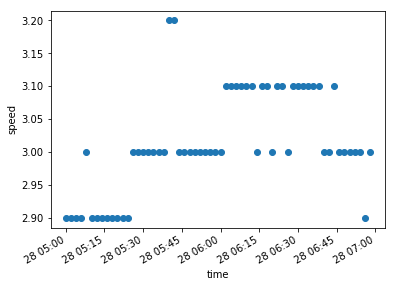

In [26]:
currents.speed.plot(marker='o', linestyle='None')

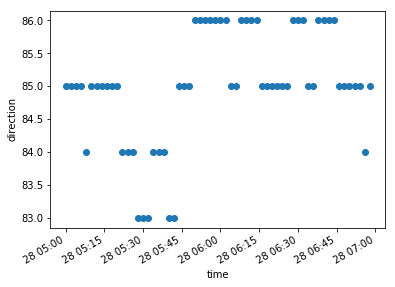

In [27]:
currents.direction.plot(marker='o', linestyle='None')

## Assemble a Month-long netCDF4 File

In [28]:
def csv_to_dataset(csv_file):
    df = pandas.read_csv(csv_file, skiprows=3)
    df = df.loc[df.MMSI == 3160171].drop_duplicates().set_index('Time')
    df = df.dropna(axis='columns', how='all')
    for col in ['Name', 'MMSI', 'Air Temp.', 'Water Temp.', 'Water Level']:
        try:
            df = df.drop([col], axis='columns')
        except KeyError:
            pass
    df.index = pandas.to_datetime(df.index, format='%d/%m/%Y %H:%M')
    df.index.name = 'time'
    df.columns = ('speed', 'direction')
    return xarray.Dataset.from_dataframe(df)

In [85]:
!rm /tmp/baz.nc

In [86]:
attrs = {
    'speed': {
        'name': 'speed',
        'units': 'm/s',
        'ioos_category': 'currents',
        'standard_name': 'sea_water_speed',
        'long_name': 'Current Speed',
    },
    'direction': {
        'name': 'direction',
        'units': 'degree',
        'ioos_category': 'currents',
        'standard_name': 'sea_water_direction',
        'long_name': 'Current Direction',
    },
}

In [87]:
ais_path = Path('/opp/observations/AISDATA')
datetime_fmt = 'YYYYMMDDTHHmmss'
utc_start_hr = arrow.get('2018-09-01 00:00')
utc_offset = utc_start_hr.to('local').utcoffset()
csv_filename = f'{utc_start_hr.format(datetime_fmt)}Z-{utc_start_hr.shift(hours=+1).format(datetime_fmt)}Z.csv'
print(csv_filename)
ds = csv_to_dataset(ais_path/csv_filename)
ds['time'] -= pandas.to_timedelta(utc_offset)
for var in attrs:
    ds[var].attrs = attrs[var]
ds.to_netcdf('/tmp/baz.nc', mode='w', encoding=encoding, unlimited_dims='time')
ds.close()

20180901T000000Z-20180901T010000Z.csv


In [88]:
for hr in arrow.Arrow.range('hour', start=utc_start_hr.shift(hours=+1), end=utc_start_hr.shift(months=+1, hours=-1)):
    with xarray.open_dataset('/tmp/baz.nc') as stored_obs:
        csv_filename = f'{hr.format(datetime_fmt)}Z-{hr.shift(hours=+1).format(datetime_fmt)}Z.csv'
        new_obs = csv_to_dataset(ais_path/csv_filename)
        new_obs['time'] -= pandas.to_timedelta(utc_offset)
        for var in attrs:
            new_obs[var].attrs = attrs[var]
        extended_obs = xarray.concat((stored_obs, new_obs), dim='time')
    # Drop repeated times because some files contain hh:00 to hh+1:00 instead of ending at hh:58
    _, index = numpy.unique(extended_obs.time.values, return_index=True)
    extended_obs = extended_obs.isel(time=index)
    extended_obs.to_netcdf('/tmp/baz.nc', mode='w', encoding=encoding, unlimited_dims='time')

### Inspect the netCDF File

In [89]:
!ls -l /tmp/baz.nc

-rw-r--r-- 1 doug doug 269555 Oct 11 19:25 /tmp/baz.nc


In [90]:
!ls -lh /tmp/baz.nc

-rw-r--r-- 1 doug doug 264K Oct 11 19:25 /tmp/baz.nc


<xarray.Dataset>
Dimensions:    (time: 21073)
Coordinates:
  * time       (time) datetime64[ns] 2018-09-01 ... 2018-09-30T23:58:00
Data variables:
    speed      (time) float32 ...
    direction  (time) float32 ...
<xarray.DataArray 'time' ()>
array('2018-09-01T00:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2018-09-30T23:58:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'speed' (time: 21073)>
array([1.2, 1.2, 1.1, ..., 0.5, 0.6, 0.6], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01 ... 2018-09-30T23:58:00
Attributes:
    name:           speed
    units:          m/s
    ioos_category:  currents
    standard_name:  sea_water_speed
    long_name:      Current Speed
<xarray.DataArray 'direction' (time: 21073)>
array([85., 83., 83., ..., 91., 92., 93.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-01 ... 2018-09-30T23:58:00
Attributes:
    name:           direction
    units:          degree
   

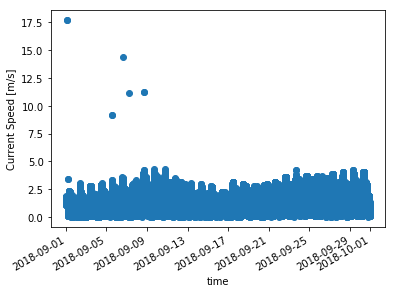

In [91]:
with xarray.open_dataset('/tmp/baz.nc') as currents:
    print(currents)
    print(currents.time.min())
    print(currents.time.max())
    print(currents.speed)
    print(currents.direction)
    currents.speed.plot(marker='o', linestyle='None')

## Initialize ERDDAP Dataset with 2017-11-20 14:00 Hour Observations

2017-11-20 14:00 Pacific time is when Michael started the hourly storage of `csv` files
from the Vancouver Fraser Port Authority (VFPA) AIS feed.

In [78]:
utc_start_hr = arrow.get('2017-11-20 22:00')
utc_offset = utc_start_hr.to('local').utcoffset()
netcdf_filename = f'VFPA_2ND_NARROWS_HADCP_2s_{utc_start_hr.format("YYYYMM")}.nc'

In [79]:
!rm '/tmp/{netcdf_filename}'

In [81]:
csv_filename = f'{utc_start_hr.format(datetime_fmt)}Z-{utc_start_hr.shift(hours=+1).format(datetime_fmt)}Z.csv'
print(csv_filename)
ds = csv_to_dataset(ais_path/csv_filename)
ds['time'] -= pandas.to_timedelta(utc_offset)
for var in attrs:
    ds[var].attrs = attrs[var]
ds.to_netcdf(f'/tmp/{netcdf_filename}', mode='w', encoding=encoding, unlimited_dims='time')
ds.close()

20171120T220000Z-20171120T230000Z.csv


<xarray.Dataset>
Dimensions:    (time: 31)
Coordinates:
  * time       (time) datetime64[ns] 2017-11-20T22:00:00 ... 2017-11-20T23:00:00
Data variables:
    speed      (time) float32 ...
    direction  (time) float32 ...
<xarray.DataArray 'time' ()>
array('2017-11-20T22:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2017-11-20T23:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'speed' (time: 31)>
array([0.4, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
       0.9, 0.9, 1. , 1. , 1. , 1.2, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, 1.2, 1.2,
       1.3, 1.3, 1.3], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-11-20T22:00:00 ... 2017-11-20T23:00:00
Attributes:
    name:           speed
    units:          m/s
    ioos_category:  currents
    standard_name:  sea_water_speed
    long_name:      Current Speed
<xarray.DataArray 'direction' (time: 31)>
array([86., 88., 90., 90., 93., 96., 96., 96., 95., 95., 92., 88., 88.

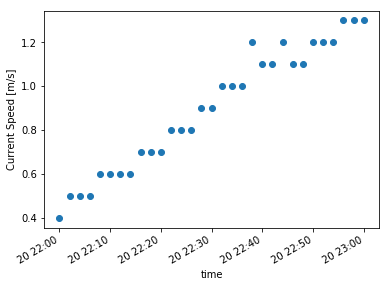

In [82]:
with xarray.open_dataset(f'/tmp/{netcdf_filename}') as currents:
    print(currents)
    print(currents.time.min())
    print(currents.time.max())
    print(currents.speed)
    print(currents.direction)
    currents.speed.plot(marker='o', linestyle='None')

Confirm that we can append "new" observations to the initial file:

In [83]:
for hr in arrow.Arrow.range('hour', start=utc_start_hr.shift(hours=+1), end=utc_start_hr.shift(days=+0, hours=+4)):
    with xarray.open_dataset(f'/tmp/{netcdf_filename}') as stored_obs:
        csv_filename = f'{hr.format(datetime_fmt)}Z-{hr.shift(hours=+1).format(datetime_fmt)}Z.csv'
        new_obs = csv_to_dataset(ais_path/csv_filename)
        new_obs['time'] -= pandas.to_timedelta(utc_offset)
        for var in attrs:
            new_obs[var].attrs = attrs[var]
        extended_obs = xarray.concat((stored_obs, new_obs), dim='time')
    # Drop repeated times because early files contain hh:00 to hh+1:00 instead of ending at hh:58
    _, index = numpy.unique(extended_obs.time.values, return_index=True)
    extended_obs = extended_obs.isel(time=index)
    extended_obs.to_netcdf(f'/tmp/{netcdf_filename}', mode='w', encoding=encoding, unlimited_dims='time')

<xarray.Dataset>
Dimensions:    (time: 151)
Coordinates:
  * time       (time) datetime64[ns] 2017-11-20T22:00:00 ... 2017-11-21T03:00:00
Data variables:
    speed      (time) float32 ...
    direction  (time) float32 ...
<xarray.DataArray 'time' ()>
array('2017-11-20T22:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()>
array('2017-11-21T03:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'speed' (time: 151)>
array([0.4, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
       0.9, 0.9, 1. , 1. , 1. , 1.2, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, 1.2, 1.2,
       1.3, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.1, 1.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.8,
       0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.6, 0.4, 0.4, 0.4,
       0.4, 0.4,

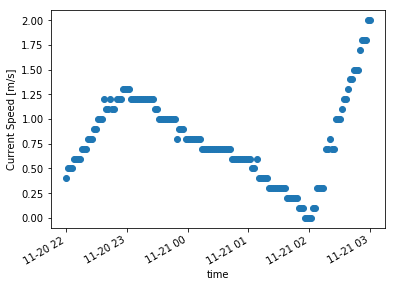

In [84]:
with xarray.open_dataset(f'/tmp/{netcdf_filename}') as currents:
    print(currents)
    print(currents.time.min())
    print(currents.time.max())
    print(currents.speed)
    print(currents.direction)
    currents.speed.plot(marker='o', linestyle='None')